# Owl
## A Retirement Planning Laboratory

This package is a retirement modeling framework for exploring the sensitivity of retirement financial decisions. Strictly speaking, it is not a planning tool, but more an environment for exploring *what if* scenarios. It provides different realizations of a financial strategy. One can certainly have a savings plan, but due to the volatility of financial investments, it is impossible to have a certain asset earnings plan. This does not mean one cannot make decisions. These decisions need to be guided with an understanding of the sensitivity of the parameters.This is exactly where this tool fits it. Given your savings and spending desires, it can generate different future realizations of your strategy under different market assumptions, helping to better understand your financial situation.

The algorithm in Owl is using the open-source HiGHS linear programming solver.
The complete formulation and detailed description of the undelying
mathematical model can be found
[here](https://raw.githubusercontent.com/mdlacasse/Owl/main/docs/owl.pdf).

Copyright - Martin-D. Lacasse (2024)

Disclaimers: *I am not a financial planner. You make your own decisions. This program comes with no guarantee. Use at your own risk.*

### <span style="color: blue"> README FIRST </span>
<span style="color:black;background:yellow;font-weight:bold">
Don't make changes directly to this file. Keep it as a working example. Therefore, it is recommended that you build your own case by making a copy of the template files provided where you will be able to enter your own numbers and explore your own assumptions.
</span>

# Tutorial 2 - Using the case of Jack and Jill
This tutorial shows how to use advanced capabilities of Owl such as Monte Carlo simulations and running simulations over a historical range. We use the same case as the one in Tutorial 1. 

### Just some Python module bookkeeping
This command needs to be at the beginning of every Owl notebook.

In [1]:
import owl

In [2]:
owl.setVerbose(True)

Setting verbose to True


### Creating the plan (see tutorial 1 for details)
We first create a plan as we did in the *Tutorial 1*. We removed the comments for reducing the clutter.

In [3]:
plan = owl.Plan(['Jack', 'Jill'], [1962, 1965], [89, 92], 'jack+jill-spending-MC')

Preparing scenario of 34 years for 2 individuals.
          Jack: life horizon from 2024 -> 2051.
          Jill: life horizon from 2024 -> 2057.
Problem has 8 distinct time series forming 992 decision variables.
Setting 1st-year starting date to 11/19.


In [4]:
plan.setAccountBalances(
    taxable=[90, 60],
    taxDeferred=[600, 150],
    taxFree=[50 + 20, 40],
)

Taxable balances: $90,000 $60,000
Tax-deferred balances: $600,000 $150,000
Tax-free balances: $70,000 $40,000
Sum of all savings accounts: $1,010,000
Post-tax total wealth of approximately $785,000


In [5]:
plan.readContributions('jack+jill.xlsx')

Reading wages, contributions, conversions, and big-ticket items over time for Jack...
Reading wages, contributions, conversions, and big-ticket items over time for Jill...
Successfully read time horizons from file "jack+jill.xlsx".


Asset allocation interpolation method set to s-curve.
Jack : Setting gliding allocation ratios (%) to individual
	 [60, 40, 0, 0] -> [70, 30, 0, 0]
Jill : Setting gliding allocation ratios (%) to individual
	 [60, 40, 0, 0] -> [70, 30, 0, 0]
Interpolating assets allocation ratios using s-curve method.


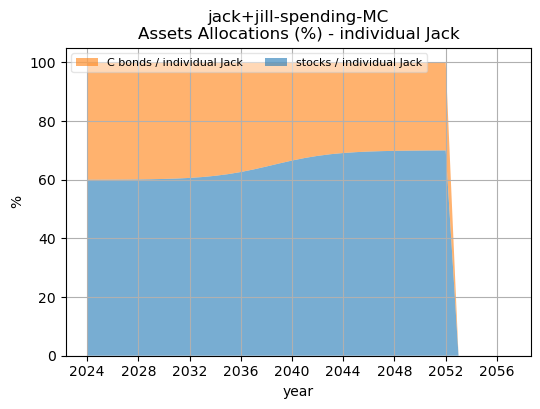

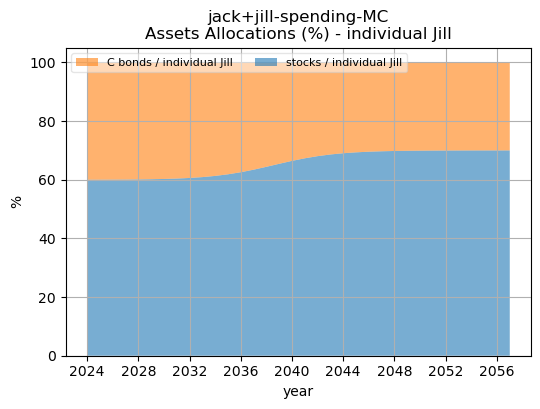

In [6]:
plan.setInterpolationMethod('s-curve')
plan.setAllocationRatios(
    'individual',
    generic=[[[60, 40, 0, 0], [70, 30, 0, 0]], [[60, 40, 0, 0], [70, 30, 0, 0]]],
)
plan.showAllocations()

In [7]:
plan.setPension([0, 10], [65, 65])
plan.setSocialSecurity([28, 25], [70, 70])

Setting pension of ['$0', '$10,000'] at age(s) [65, 65]
Setting social security benefits of ['$28,000', '$25,000'] at age(s) [70, 70]


Setting smile spending profile.
Securing 60% of spending amount for surviving spouse.


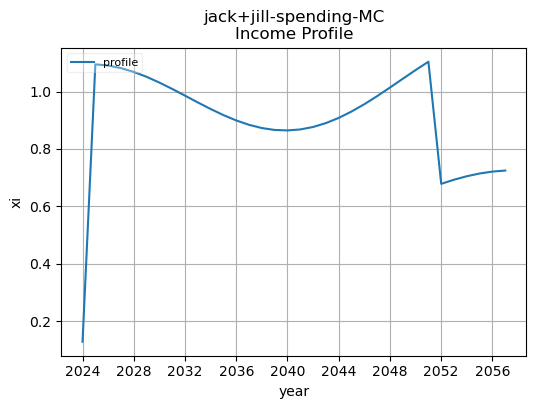

In [8]:
plan.setSpendingProfile('smile', 60)
plan.showProfile()

#### Using stochastic rates
We set the rates to *stochastic* with return values of 8% +/- 17% for the S&P 500, 5% +/- 8% for corporate bonds, 4% +/- 8% for T-notes, and 3% +/- 2% for the inflation/common assets. The correlation matrix was obtained from historical data using the year range of your choice, for example,

    owl.getRatesDistributions(1970, 2019)
    

In [9]:
my_means = [8, 5, 4, 3]
my_stdev = [17, 8, 8, 2]
# my_corr = [[1, 0.46, 0.06, -.12], [0.46, 1, 0.68, -.27], [0.06, 0.68, 1, -.21], [-.12, -.27, -.21, 1]]
offdiag_corr = [.46, .06, -.12, .68, -.27, -.21]
plan.setRates('stochastic', values=my_means, stdev=my_stdev, corr=offdiag_corr)

Setting rates using stochastic method with means: 8.0% 5.0% 4.0% 3.0%
	 standard deviations: 17.0% 8.0% 8.0% 2.0%
	 and correlation matrix:
		 [[ 1.    0.46  0.06 -0.12]
		 [ 0.46  1.    0.68 -0.27]
		 [ 0.06  0.68  1.   -0.21]
		 [-0.12 -0.27 -0.21  1.  ]]
Generating rate series of 34 years using stochastic method.


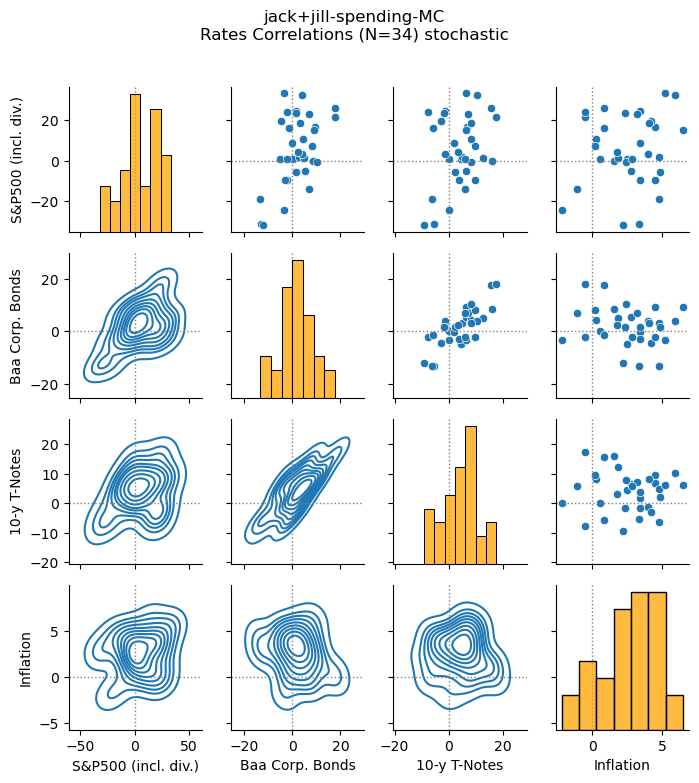

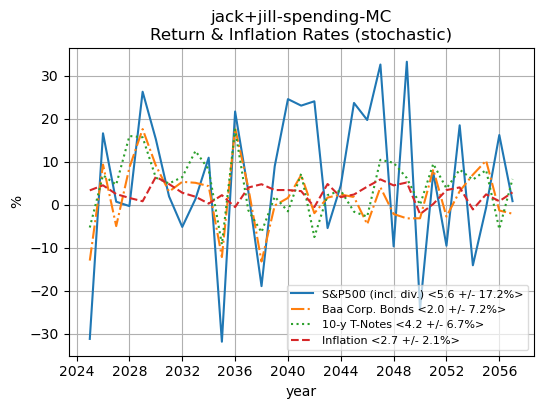

In [10]:
# Display one instance resulting from this choice.
plan.showRatesCorrelations(shareRange=False)
plan.showRates()

In [11]:
plan.setHeirsTaxRate(33)
plan.setLongTermCapitalTaxRate(15)

Heirs tax rate on tax-deferred portion of estate set to 33%.
Long-term capital gain income tax set to 15%.


### Preparing the case to run
We still limit Roth conversions to a maximum of $150k for Jack only. 

In [12]:
options = {'maxRothConversion': 150, 'noRothConversions': 'Jill'}

### Running Monte Carlo simulations
In order to run Monte Carlo simulations, one has first to set the rates to either *stochastic* or 'histochastic*. Then a call to `runMC()` specifying the objective and options is made. The last argument is the number of cases to consider. Unlike event-driven simulator, Owl performs an optimization for each case, which adds considerable computing costs. For this reason, the default behavior of Owl is to turn off Medicare calculations for these runs. It can be turned back on using 'withMedicare' to `True` in the options. But this will significantly increase the computer time while providing little more insight.

Running 500 cases takes about 5 min to complete. Be patient. At the end of the run, a histogram of the net spending values is displayed.

When running $N$ cases, the error on the estimate for the mean is decreasing as $1/\sqrt{N - 1}$. Therefore, 500 cases are more than sufficient to obtain reliable and meaningful estimates of mean statistics.

Jack and Jill desire to leave a bequest of \\$500k (in today's \\$). What are these cases tell us?

In [13]:
%%time
options['bequest'] = 500
plan.runMC('maxSpending', options, 40000);

UnboundLocalError: cannot access local variable 'myoptions' where it is not associated with a value

All cases can leave a \\$500k bequest, but the net spending for achieving this constraint can lead to a small value in some scenarios. However, the median value for the net spending is about \\$86k, close to the \\$90k desired by Jack and Jill. A more practical example is to look at the maximum bequest left under the constraint of a fixed net spending.

In [14]:
%%time
options['netSpending'] = 90
plan.runMC('maxBequest', options, 40000);

UnboundLocalError: cannot access local variable 'myoptions' where it is not associated with a value

In this case, a large fraction of scenarios are successful in providing the desired \\$90k net spending amount over the duration of the plan. The median bequest left at the end of the plan is close to \\$1 M, twice what Jack and Jill are intending to leave. This might first suggest that the amount of \\$90k might be too conservative on average. The success rate is 85%, which is good, as Jack and Jill are able to adjust to the situation as further estimates are performed in the future.

### Running cases over a historical range
We can also run cases over a range of years and compile the outcome in a histogram. For this purpose, there is no need to pre-select specific rates using the `setRates()` method as the choice of historical rates is implicit. Only the year range is required.

Let's look at a specific example. For optimizing the net spending amount, we specify *maxSpending* in the following call to optimize the plan over the 63 years following 1928:

In [ ]:
%%time
plan.runHistoricalRange('maxSpending', options, 1928, 1990);

|--- progress ---|
	57%

The historical data suggests a larger value than the one dictated from when only looking at the year 1969.

In [ ]:
%%time
plan.runHistoricalRange('maxBequest', options, 1928, 1990);

The success rate of historical data is 100%. This is not surprising as the original estimates for the net spending and the bequest were derived from running a case in 1969, the second next worst year of historical sequence of returns. 